In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
import cv2
import types

from utils import *

In [2]:
j = json.load(open('data/annotations.json'))

In [3]:
j[0]['annotations'][0]

{'class': 'fluke',
 'height': 372.0,
 'type': 'rect',
 'width': 1017.0,
 'x': 14.0,
 'y': 97.0}

The above annotations are in coco dataset format (x, y, width, height). The fastai library expects bbox coordinates to be in the format of (y_upper_left, x_upper_left, y_lower_right, x_lower_right) with the origin being in the upper left hand corner of the image.

In [4]:
SZ = 224
BS = 64
NUM_WORKERS = 12

In [5]:
def anno2bbox(anno):
    im_width, im_height = PIL.Image.open(f"data/train/{anno['filename']}").size
    anno = list(filter(lambda a: a['class'] == 'fluke', anno['annotations']))[0]
    return [
        np.clip(anno['y'], 0, im_height) / im_height * SZ,
        np.clip(anno['x'], 0, im_width) / im_width * SZ,
        np.clip(anno['y']+anno['height'], 0, im_height) / im_height * SZ,
        np.clip(anno['x']+anno['width'], 0, im_width) / im_width * SZ
    ]

Just some small functions that will be helpful as we construct our dataset.

In [6]:
fn2bbox = {jj['filename']: [[anno2bbox(jj)], ['fluke']] for jj in j}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)
get_y_func = lambda o: fn2bbox[path2fn(o)]

In [7]:
val_fns = pd.read_pickle('data/val_fns_detection.pkl') # I create this file in fluke_detection.ipynb

ObjectCategoryList is designed to be used in a full object recognition scenario (multiple bounding boxes per image, objects of multiple classes). Since that is more functionality than we require (and more than our model will predict - our objects will always be of the same class, 'fluke', and we will be predicting just a single bounding box per image) I make minor changes to ObjectCategoryList.

In [8]:
class StubbedObjectCategoryList(ObjectCategoryList):
    def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()]

In [9]:
data = (ObjectItemList.from_df(pd.DataFrame(data=list(fn2bbox.keys())), path='data/train-224')
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)                         
        .label_from_func(get_y_func, label_cls=StubbedObjectCategoryList)
        .transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats))

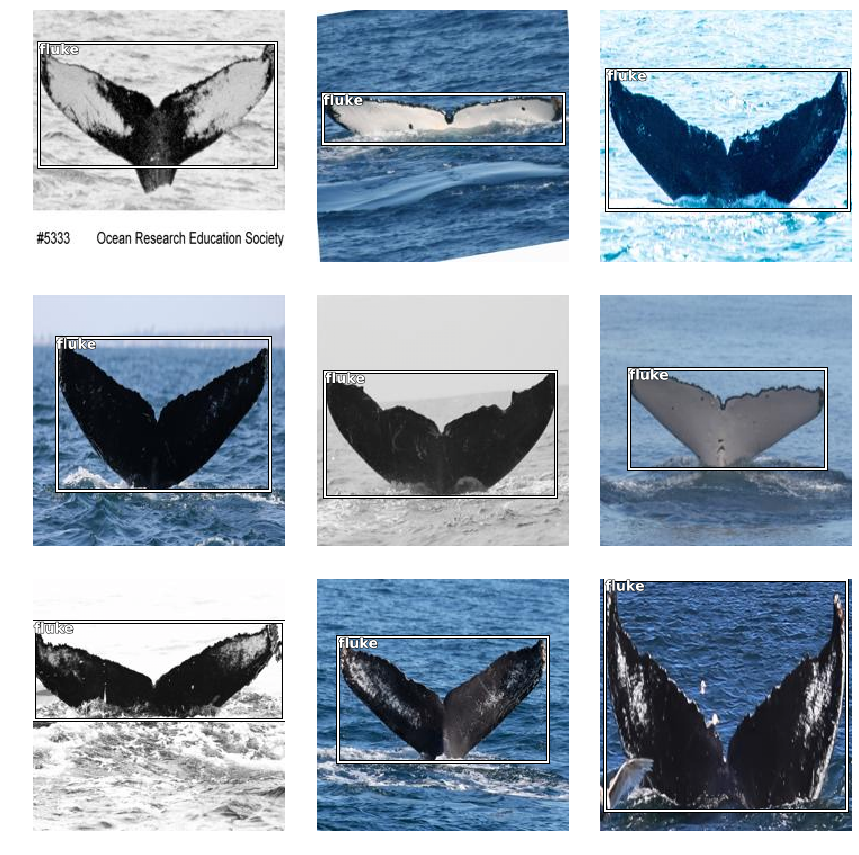

In [10]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(12,12))

In [11]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

In [12]:
def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

In [13]:
learn = Learner(data, FlukeDetector(arch=models.resnet50), loss_func=loss_fn)
learn.metrics = [lambda preds, targs, _: IoU(preds, targs.squeeze()).mean()]

In [14]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [15]:
learn.freeze_to(-1)

In [16]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,
1,0.772527,0.798867,0.000000
2,0.763410,0.800455,0.000548
3,0.725678,0.800279,0.017194
4,0.639308,0.220938,0.564017
5,0.530437,0.157470,0.667477
6,0.450821,0.168413,0.646527
7,0.392218,0.156084,0.653809
8,0.348442,0.140046,0.665435
9,0.314346,0.121695,0.706105
10,0.286541,0.114142,0.724231


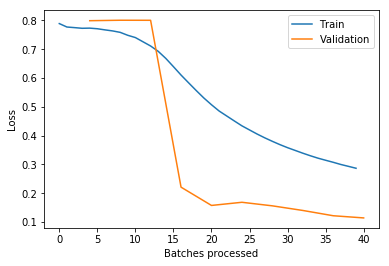

In [17]:
learn.recorder.plot_losses()

In [18]:
learn.unfreeze()

In [19]:
max_lr = 2e-3
lrs = [max_lr/100, max_lr/10, max_lr]

In [20]:
learn.fit_one_cycle(40, lrs, div_factor=20)

epoch,train_loss,valid_loss,
1,0.117067,0.107134,0.740147
2,0.115032,0.104660,0.745270
3,0.114068,0.105499,0.742223
4,0.111720,0.100619,0.749310
5,0.110276,0.095699,0.756791
6,0.108149,0.090163,0.769526
7,0.106420,0.095683,0.756616
8,0.105466,0.089593,0.757499
9,0.103375,0.088832,0.762985
10,0.101511,0.090514,0.766422


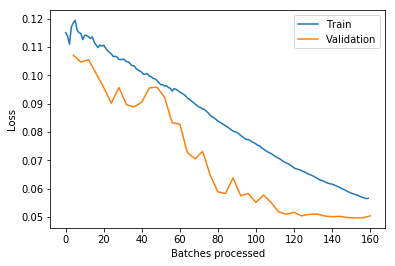

In [21]:
learn.recorder.plot_losses()

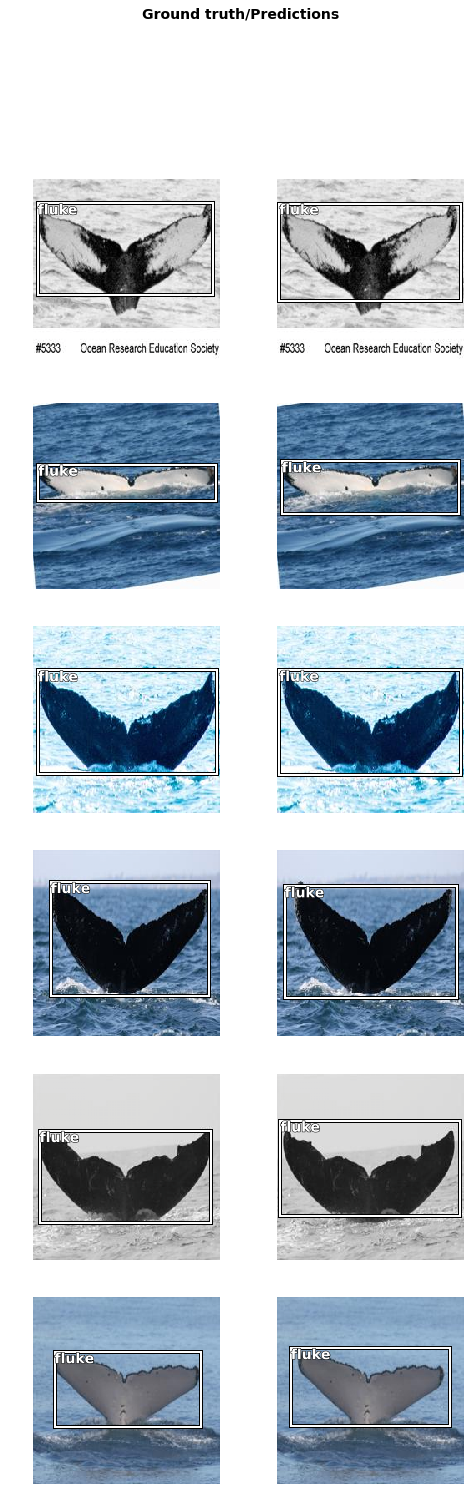

In [22]:
learn.show_results(rows=6)

In [ ]:
# preds, targs = learn.get_preds()

# predicted_bboxes = ((preds + 1) / 2 * SZ).numpy()
# targets = ((targs + 1) / 2 * SZ).numpy().squeeze()

# def draw_bbox(img, bbox, target=None, color=(255, 0, 0), thickness=2):
#     y_min, x_min, y_max, x_max = map(int, bbox)
#     cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
#     if target is not None:
#         y_min, x_min, y_max, x_max = map(int, target)
#         cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
#     return img

# def cv_read(path):    
#     im = cv2.imread(path, cv2.IMREAD_COLOR)
#     return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# # Targets are in green, predictions in red.
# ims = np.stack([draw_bbox(cv_read(data.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(9)])
# plt.figure(figsize=(12,12))
# plt.axis('off')
# plt.imshow(montage(np.stack(ims), multichannel=True))